# Application d'un Transformer sur notre jeu de texte

In [1]:
import h5py
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import torch

In [2]:
# Loading the 2 CSVs
X = pd.read_csv( 'X_train.csv', delimiter=',', index_col=0)
y = pd.read_csv( 'Y_train.csv', delimiter=',', index_col=0)

In [3]:
# On met de côté un jeu de test auquel on ne touchera pas jusqu'à la fin, au moment de mesurer la performance du modèle retenu
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [4]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['prdtypecode'])

In [5]:
from datasets import Dataset

# Convertir les données en DataFrame
df = pd.DataFrame(X, columns=['designation'])
df.rename(columns={'designation': 'text'}, inplace=True)
df['label'] = y_encoded

# Créer un dataset Hugging Face à partir du DataFrame
dataset = Dataset.from_pandas(df)

In [6]:
# Fraction des données à allouer à l'ensemble de validation
validation_split = 0.2

# Diviser le dataset
train_test_dataset = dataset.train_test_split(test_size=validation_split)

# Récupérer les datasets d'entraînement et de validation
train_dataset = train_test_dataset['train']
val_dataset = train_test_dataset['test']

## Choix de XLM-RoBERTa (car multilingue) - Tokenization et encodage

In [7]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# Charger le tokenizer et le modèle pré-entraîné
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLMRobertaModel.from_pretrained('xlm-roberta-base').to(device)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/home/nans/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [8]:
train_test_dataset.reset_format()

In [7]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [10]:
dataset_encoded = train_test_dataset.map(tokenize, batched=True, batch_size=32)

Map:   0%|          | 0/54345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13587 [00:00<?, ? examples/s]

In [8]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k: torch.stack([v_.to(device) for v_ in v]) if isinstance(v, list) else v.to(device) 
              for k, v in batch.items() if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
    

In [12]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [13]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/54345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13587 [00:00<?, ? examples/s]

In [69]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape

((54345, 768), (13587, 768))

In [57]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer, Trainer, TrainingArguments

num_labels = 27
model_ckpt = 'xlm-roberta-base'
# Charger le tokenizer et le modèle
#tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device) 


In [58]:
labels = label_encoder.classes_

In [59]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [60]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = max(1, len(dataset_encoded["train"]) // batch_size)
model_name = f"{model_ckpt}-finetuned-raw"
training_args = TrainingArguments(output_dir=model_name,
                num_train_epochs=4,
                learning_rate=2e-5,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                weight_decay=0.01,
                evaluation_strategy="epoch",
                disable_tqdm=False,
                logging_steps=logging_steps,
                push_to_hub=True,
                log_level="error")

/home/nans/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=dataset_encoded["train"],
            eval_dataset=dataset_encoded["test"],
            tokenizer=tokenizer)

trainer.train();

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.270500,0.737620,0.781556,0.776268
2,0.635900,0.582955,0.825127,0.823786
3,0.482000,0.547560,0.838817,0.836617
4,0.387300,0.538930,0.843306,0.841895


In [62]:
# Chemin où vous souhaitez sauvegarder le modèle
output_dir = "../models/"

# Sauvegarder le modèle entraîné
model.save_pretrained(output_dir)

In [63]:
trainer.save_model("transformers/")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [64]:
# Obtenir les prédictions sur l'ensemble de validation
predictions = trainer.predict(dataset_encoded["test"])


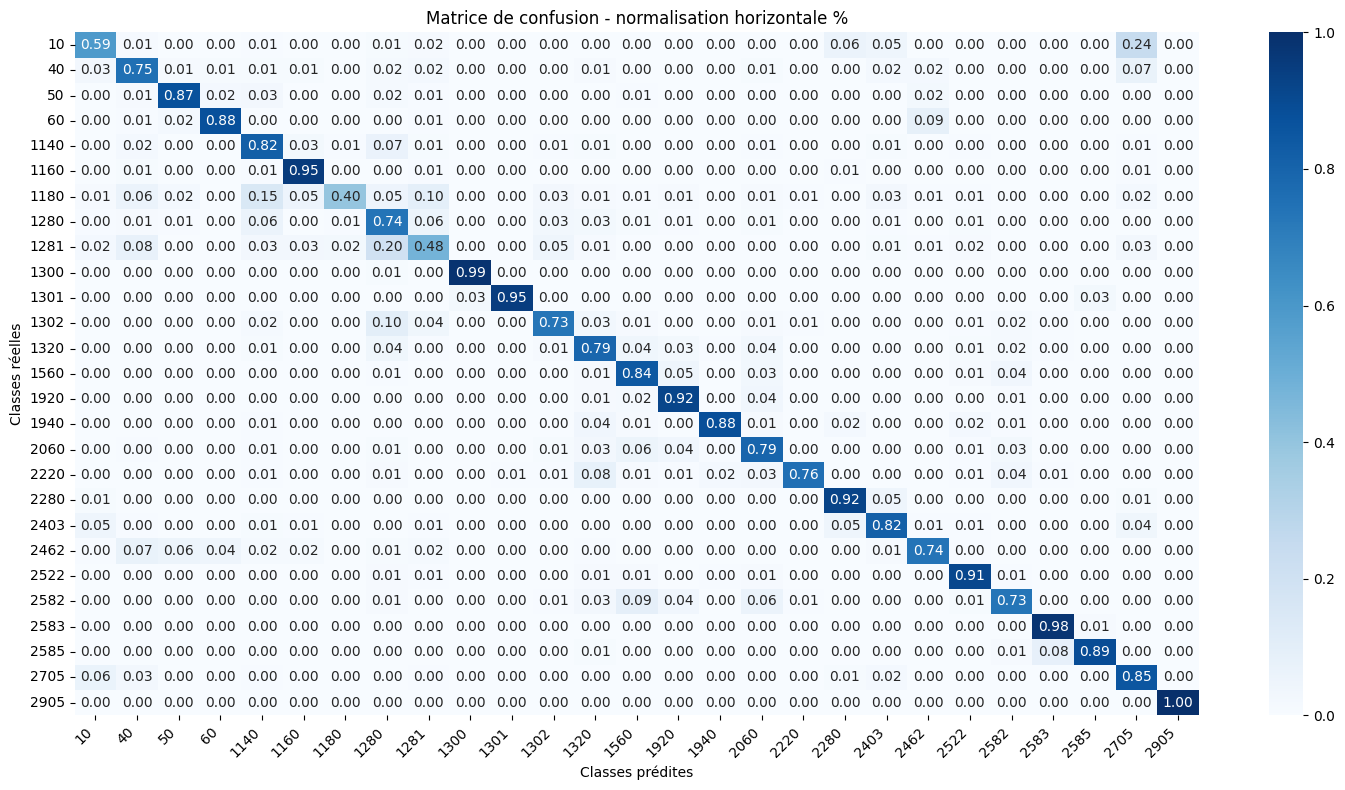

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(predictions.predictions, axis=1)
normalized_cm = confusion_matrix(y_valid, y_preds, normalize="true")

import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Matrice de confusion - normalisation horizontale %')
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')

# Rotation des étiquettes des axes pour éviter les chevauchements
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Ajustement de l'espacement pour que tout soit bien visible
plt.tight_layout()

plt.show()

In [71]:
from sklearn.metrics import classification_report

report = classification_report(np.array(y_valid), np.array(y_preds), target_names=list(map(str,label_encoder.classes_)))
print(report)

              precision    recall  f1-score   support

          10       0.74      0.59      0.66       523
          40       0.72      0.75      0.73       365
          50       0.87      0.87      0.87       295
          60       0.86      0.88      0.87       138
        1140       0.73      0.82      0.77       435
        1160       0.93      0.95      0.94       640
        1180       0.75      0.40      0.52       134
        1280       0.71      0.74      0.72       759
        1281       0.56      0.48      0.52       321
        1300       0.99      0.99      0.99       812
        1301       0.97      0.95      0.96       115
        1302       0.80      0.73      0.77       415
        1320       0.73      0.79      0.76       485
        1560       0.82      0.84      0.83       794
        1920       0.86      0.92      0.89       674
        1940       0.84      0.88      0.86       141
        2060       0.84      0.79      0.82       861
        2220       0.87    

## Evaluation du jeu de test conservé depuis le départ car meilleur modèle sélectionné

In [9]:
label_encoder = LabelEncoder()
y_encoded_test = label_encoder.fit_transform(y_test['prdtypecode'])

In [10]:
from datasets import Dataset

# Convertir les données en DataFrame
df = pd.DataFrame(X_test, columns=['designation'])
df.rename(columns={'designation': 'text'}, inplace=True)
df['label'] = y_encoded_test

# Créer un dataset Hugging Face à partir du DataFrame
dataset_test = Dataset.from_pandas(df)

In [11]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# Charger le tokenizer et le modèle pré-entraîné
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLMRobertaModel.from_pretrained('xlm-roberta-base').to(device)

C:\Users\Nans\miniconda3\envs\torch2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
dataset_encoded_test = dataset_test.map(tokenize, batched=True, batch_size=32)

Map:   0%|          | 0/16984 [00:00<?, ? examples/s]

In [13]:
dataset_encoded_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [14]:
dataset_hidden_test = dataset_encoded_test.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/16984 [00:00<?, ? examples/s]

In [15]:
X_test = np.array(dataset_hidden_test["hidden_state"])
y_test = np.array(dataset_hidden_test["label"])


In [16]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

# Charger le modèle et le tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('../models/transformers/')
tokenizer = XLMRobertaTokenizer.from_pretrained('../models/transformers/')

In [17]:
from transformers import Trainer, TrainingArguments

num_labels = 27
model_ckpt = 'xlm-roberta-base'

batch_size = 32
logging_steps = max(1, len(dataset_encoded_test) // batch_size)
model_name = f"{model_ckpt}-finetuned-raw"
training_args = TrainingArguments(output_dir=model_name,
                num_train_epochs=5,
                learning_rate=2e-5,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                weight_decay=0.01,
                evaluation_strategy="epoch",
                disable_tqdm=False,
                logging_steps=logging_steps,
                push_to_hub=True,
                log_level="error")


In [18]:
from transformers import Trainer

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=dataset_encoded_test,
    tokenizer=tokenizer
)

C:\Users\Nans\miniconda3\envs\torch2\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [19]:
preds_output = trainer.predict(dataset_encoded_test)

In [20]:
y_preds = np.argmax(preds_output.predictions, axis=1)

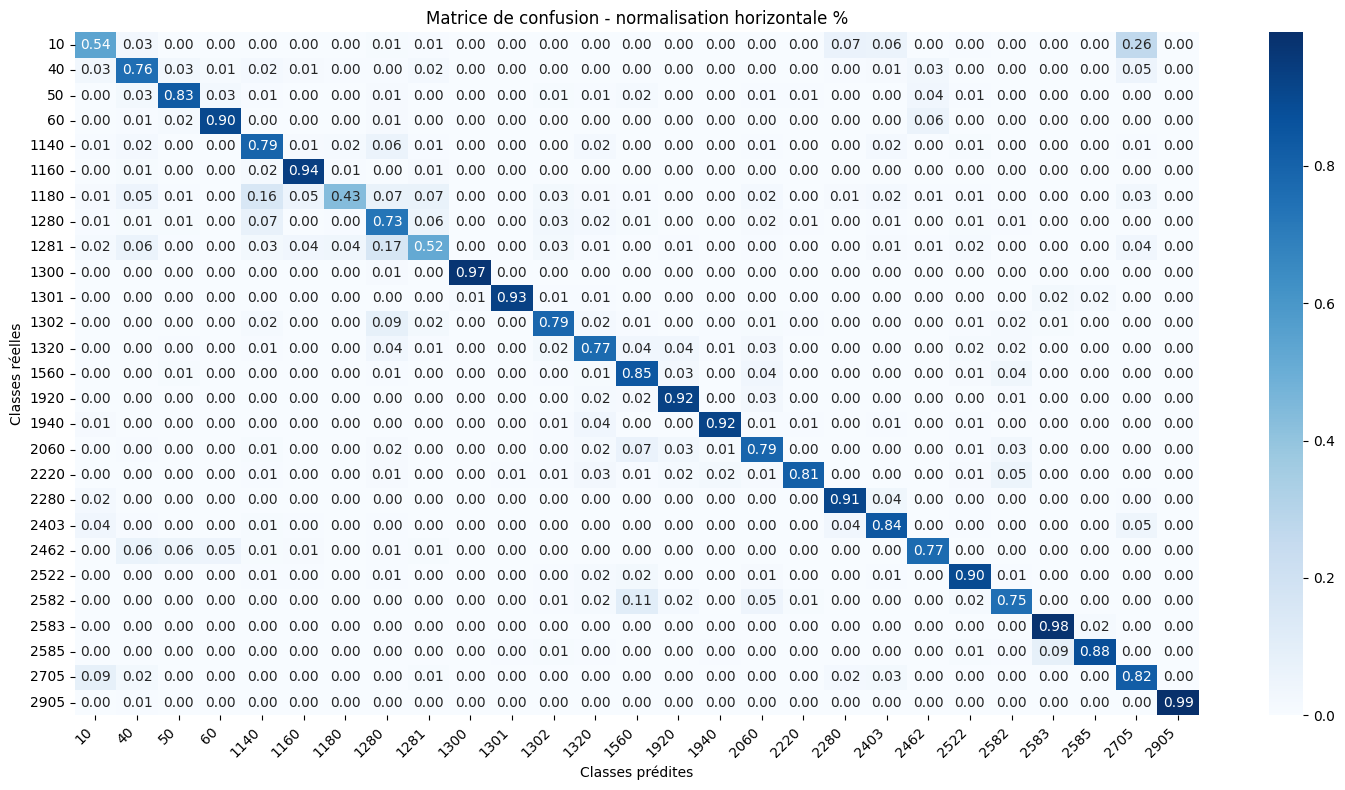

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

normalized_cm = confusion_matrix(y_test, y_preds, normalize="true")

import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Matrice de confusion - normalisation horizontale %')
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')

# Rotation des étiquettes des axes pour éviter les chevauchements
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Ajustement de l'espacement pour que tout soit bien visible
plt.tight_layout()

plt.show()

In [22]:
from sklearn.metrics import classification_report

report = classification_report(np.array(y_test), np.array(y_preds), target_names=list(map(str,label_encoder.classes_)))
print(report)

              precision    recall  f1-score   support

          10       0.70      0.54      0.61       623
          40       0.74      0.76      0.75       502
          50       0.81      0.83      0.82       336
          60       0.84      0.90      0.87       166
        1140       0.71      0.79      0.75       534
        1160       0.93      0.94      0.93       791
        1180       0.61      0.43      0.50       153
        1280       0.73      0.73      0.73       974
        1281       0.62      0.52      0.57       414
        1300       0.99      0.97      0.98      1009
        1301       0.96      0.93      0.94       161
        1302       0.80      0.79      0.79       498
        1320       0.78      0.77      0.78       648
        1560       0.80      0.85      0.82      1015
        1920       0.88      0.92      0.90       861
        1940       0.84      0.92      0.88       161
        2060       0.83      0.79      0.81       999
        2220       0.86    